In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [2]:
test_data = pd.read_csv(r'C:\Users\liuch\Desktop\395\Final_Project\Spaceship_Titanic\spaceship-titanic\test_data_mode.csv')
train_data = pd.read_csv(r'C:\Users\liuch\Desktop\395\Final_Project\Spaceship_Titanic\spaceship-titanic\train_data_mode.csv')

test_passenger_id = test_data['PassengerId'].copy()
train_data.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)
test_data.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

# Convert Boolean Columns to Floats
train_data.replace({False: 0, True: 1}, inplace=True)
test_data.replace({False: 0, True: 1}, inplace=True)

# Splitting the features and target
train_y = train_data['Transported'].astype(float)
train_X = train_data.drop('Transported', axis=1).astype(float)
test_X = test_data.astype(float)

In [3]:
# Convert Boolean Columns to Floats
for col in train_X.columns:
    if train_X[col].dtype == bool:
        train_X[col] = train_X[col].astype(float)

print(train_X.dtypes)

CryoSleep                    float64
Age                          float64
VIP                          float64
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Num                          float64
Deck_A                       float64
Deck_B                       float64
Deck_C                       float64
Deck_D                       float64
Deck_E                       float64
Deck_F                       float64
Deck_G                       float64
Deck_T                       float64
Side_P                       float64
Side_S                       float64
Destination_55 Cancri e      float64
Destination_PSO J318.5-22    float64
Destination_TRAPPIST-1e      float64
HomePlanet_Earth             float64
HomePlanet_Europa            float64
HomePlanet_Mars              float64
dtype: object


In [4]:
# Convert Boolean Columns to Floats
for col in test_X.columns:
    if test_X[col].dtype == bool or test_X[col].dtype == object:
        test_X[col] = test_X[col].astype(float)

print(test_X.dtypes)

CryoSleep                    float64
Age                          float64
VIP                          float64
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Num                          float64
Deck_A                       float64
Deck_B                       float64
Deck_C                       float64
Deck_D                       float64
Deck_E                       float64
Deck_F                       float64
Deck_G                       float64
Deck_T                       float64
Side_P                       float64
Side_S                       float64
Destination_55 Cancri e      float64
Destination_PSO J318.5-22    float64
Destination_TRAPPIST-1e      float64
HomePlanet_Earth             float64
HomePlanet_Europa            float64
HomePlanet_Mars              float64
dtype: object


In [5]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

# Convert pandas dataframes to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(test_X.values, dtype=torch.float32)

# Create Tensor datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [6]:
# Define the binary classifier model
device = torch.device('cuda')

class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.dropout(x, p=0.2)
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.dropout(x, p=0.2)
        x = nn.functional.relu(self.fc3(x))
        return torch.sigmoid(self.fc4(x))

# Initialize model, loss, and optimizer
model = BinaryClassifier(X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)  # Multiply by batch size to scale the loss
    return total_loss / len(train_loader.dataset)  # Return the average loss

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item() * inputs.size(0)
    return total_loss / len(val_loader.dataset)

train_losses = []
val_losses = []

# Run training and validation
for epoch in range(75):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}: Training Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}')

Epoch 1: Training Loss = 1.0288, Validation Loss = 0.6423
Epoch 2: Training Loss = 0.5932, Validation Loss = 0.5871
Epoch 3: Training Loss = 0.5486, Validation Loss = 0.5376
Epoch 4: Training Loss = 0.5230, Validation Loss = 0.5302
Epoch 5: Training Loss = 0.5056, Validation Loss = 0.5287
Epoch 6: Training Loss = 0.4973, Validation Loss = 0.5300
Epoch 7: Training Loss = 0.4972, Validation Loss = 0.5085
Epoch 8: Training Loss = 0.4963, Validation Loss = 0.5104
Epoch 9: Training Loss = 0.4915, Validation Loss = 0.5146
Epoch 10: Training Loss = 0.4906, Validation Loss = 0.5038
Epoch 11: Training Loss = 0.4805, Validation Loss = 0.4966
Epoch 12: Training Loss = 0.4739, Validation Loss = 0.4882
Epoch 13: Training Loss = 0.4697, Validation Loss = 0.4826
Epoch 14: Training Loss = 0.4687, Validation Loss = 0.4812
Epoch 15: Training Loss = 0.4657, Validation Loss = 0.4723
Epoch 16: Training Loss = 0.4607, Validation Loss = 0.4680
Epoch 17: Training Loss = 0.4601, Validation Loss = 0.4757
Epoch 

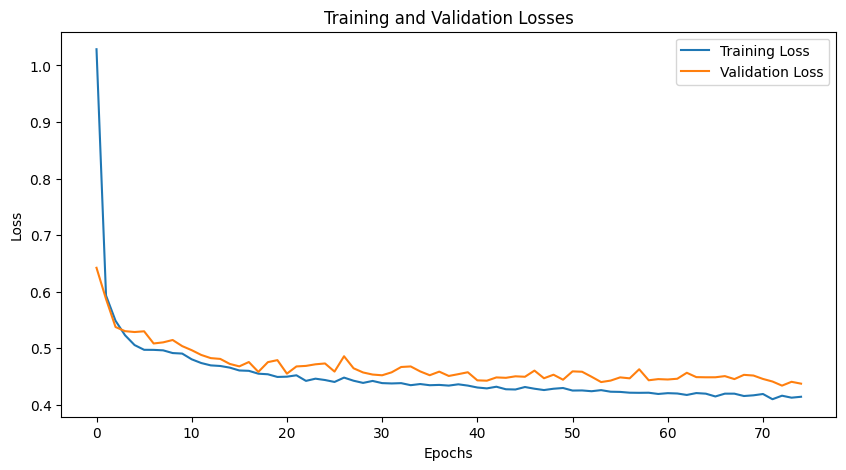

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [9]:
# Prediction on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.to(device)).squeeze()
predictions = (test_outputs >= 0.5).cpu().numpy().astype(int)

# Prepare submission DataFrame
submission_df = pd.DataFrame({
    "PassengerId": test_passenger_id,
    "Transported": predictions.astype(bool)
})
submission_df.to_csv(r'C:\Users\liuch\Desktop\395\Final_Project\Spaceship_Titanic\spaceship-titanic\submission_fcnn.csv', index=False)